In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import Sequence
from functools import reduce
from jax.tree_util import tree_map, tree_flatten, tree_unflatten
import flax.linen as nn

import visualization
from data import datasets

%load_ext autoreload
%autoreload 2
%matplotlib agg

In [2]:
dataset = datasets.Sinusoidal(normalization="standardization", rng_key=jax.random.PRNGKey(0))
X_train, y_train = dataset[:]

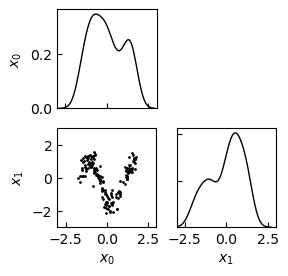

In [3]:
figure = visualization.TriangleFigure(prefix="x", settings=visualization.TriangleSettings())
figure.plot(data=dataset.data)

In [4]:
# flax nns

In [7]:
class MLP(nn.Module):
    features: Sequence[int]
    
    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.tanh(nn.Dense(feat, kernel_init=nn.initializers.zeros, bias_init=nn.initializers.zeros)(x))
        x = nn.Dense(self.features[-1], kernel_init=nn.initializers.zeros, bias_init=nn.initializers.zeros)(x)
        return x
    
    def init_from_vector(self, batch, v):
        params = self.init(jax.random.PRNGKey(0), batch)  # I do not need random behaviour here.
        leaves, treedef = tree_flatten(params)
        new_leaves = []
        accumulator = 0
        for leaf in leaves:
            size = reduce(lambda x, y: x * y, [s for s in leaf.shape])
            new_leaves.append(v[accumulator:accumulator + size].reshape(leaf.shape))
            accumulator += size
        new_params = tree_unflatten(treedef, new_leaves)
        return new_params

In [23]:
model = MLP([4, 1])
batch = jnp.ones((64, 1))
w = np.random.normal(0, 1, 13)
print(w)
params = model.init_from_vector(batch, w)
output = model.apply(params, batch)
print(params)

[-1.08951074  1.23218029 -1.20694435 -1.54915151 -1.15839751 -0.64165562
 -0.27010432 -0.26592099  0.07431301  1.47921823  0.21848605  0.7102585
  1.86358139]
FrozenDict({
    params: {
        Dense_0: {
            bias: array([-1.08951074,  1.23218029, -1.20694435, -1.54915151]),
            kernel: array([[-1.15839751, -0.64165562, -0.27010432, -0.26592099]]),
        },
        Dense_1: {
            bias: array([0.07431301]),
            kernel: array([[1.47921823],
                   [0.21848605],
                   [0.7102585 ],
                   [1.86358139]]),
        },
    },
})
